# Differential Analysis of RIBO1B vs DNA-only (rep2-2023) runs CONTROL REGION
Here several plots are produces to visulize better aligment profile is search for noise into data when comparing RIBO1B run with the DNA-only replicate 2 (2023). Here the region analyzed is a **CONTROL REGION** far from the expected region of ribos incorporation with a long stretch of T (A on reverse).

In [1]:
# import basic modules
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam

# define utils function
def get_complement(seq):
    dict_ = {"A":"T", "T":"A", "G":"C", "C":"G"}
    complement = [dict_[base] for base in seq]
    return complement

In [2]:
# define results folder and print files
results_folder = "/lustre/bio_running/DNA_Ribo_2023/results/basecalling_features_with_raw_data"
reference_filepath = "/lustre/bio_running/DNA_Ribo/refs/ref.fa"

# create a folder where to store resulting differential dna-ribo plots
results_folder_diff_plots = os.path.join(results_folder, "diff_plots")

# create results folder if it doesn't exists
if not os.path.exists(results_folder_diff_plots):
    os.mkdir(results_folder_diff_plots)

# list files into raw data results folder
os.listdir(results_folder)

['DNA only vs RIBO2 (rep2) site - Whole Primer region.ribo2.forw.tsv',
 'DNA only vs RIBO1B Large Region - Whole Primer region.dna.rev.tsv',
 'diff_plots',
 'DNA only (rep1) vs DNA only (rep2) site - Whole Primer region.dna_rep1.forw.tsv',
 'DNA only (rep1) vs DNA only (rep2) site - Whole Primer region.dna_rep2.forw.tsv',
 'DNA only vs RIBO2 (rep1) site - Whole Primer region.ribo2.rev.tsv',
 'DNA only vs RIBO1C Whole Construct.tiff',
 'DNA only vs RIBO2 (rep1) site - Whole Primer region.dna.forw.tsv',
 'DNA only vs RIBO2 (rep2) site - Whole Primer region.tiff',
 'DNA only vs RIBO2 (rep1) site - Whole Primer region.dna.rev.tsv',
 'DNA only (rep1) vs DNA only (rep2) site - Whole Primer region.dna_rep2.rev.tsv',
 'DNA only vs RIBO2 (rep2) site - Whole Primer region.dna.forw.tsv',
 'DNA only vs RIBO3 site - Whole Primer region.tiff',
 'DNA only vs RIBO1B CTRL site - Whole Primer region.tiff',
 'DNA only vs RIBO1B site - Whole Primer region.ribo1b.rev.tsv',
 'DNA only vs RIBO1B Large Region

## DNA (2023) vs RIBO1B

Lineplot version with single variables whole region.

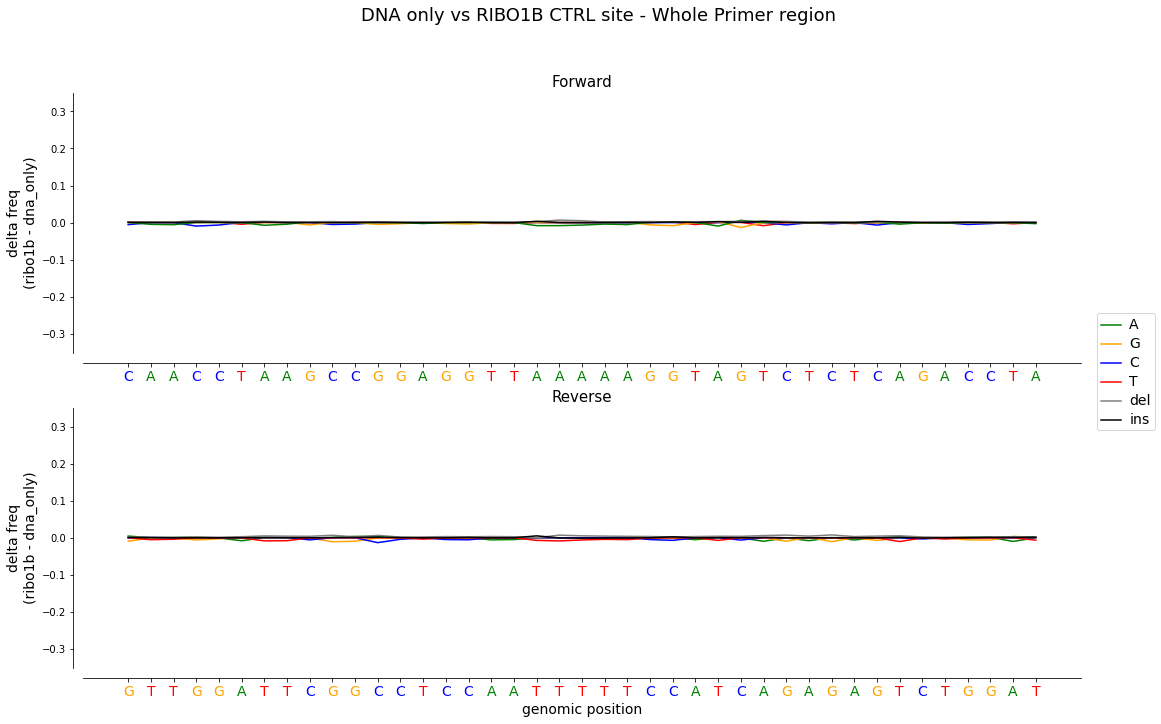

In [3]:
# open reference with pysam as FastaFile object
ref = pysam.FastaFile(reference_filepath)

# define expected sites with ribonucleotides insertion on reverse strand
sites = []

# define ribo names
ribos = []

# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

# load alignment profiles for dna and ribo for each expected "ribo" site
columns_forw = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', 'G', 'A', 'del', 'ins']
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'A', 'G', 'C', 'T', 'del', 'ins']

results_basename="DNA only vs RIBO1B CTRL site - Whole Primer region"

dna_forw = pd.read_table(os.path.join(results_folder, f"{results_basename}.dna.forw.tsv"), index_col=0)
dna_forw.columns = columns_forw
dna_rev = pd.read_table(os.path.join(results_folder, f"{results_basename}.dna.rev.tsv"), index_col=0)
dna_rev.columns = columns_rev
ribo_forw = pd.read_table(os.path.join(results_folder, f"{results_basename}.ribo1b.forw.tsv"), index_col=0)
ribo_forw.columns = columns_forw
ribo_rev = pd.read_table(os.path.join(results_folder, f"{results_basename}.ribo1b.rev.tsv"), index_col=0)
ribo_rev.columns = columns_rev

# calculate differential frequencies between dna_only and ribo runs at each strand
forw_freqs_diffs = (ribo_forw.iloc[:,-6:] - dna_forw.iloc[:,-6:])
rev_freqs_diffs = (ribo_rev.iloc[:,-6:] - dna_rev.iloc[:,-6:])

# retrieve reference sequences
start, stop = forw_freqs_diffs.index.min()-1, forw_freqs_diffs.index.max()
seq = ref.fetch("M13mp18", start, stop)
seq_rev_compl = get_complement(seq)

# convert to lists
seq = list(seq)
seq_rev_compl = list(seq_rev_compl)

# take maximum absolute values of differences in both strand to be used to determine y intervals into plots
# to note: poss columns have to be excluded
max_abs_freq  = max(forw_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
if max_abs_freq < 0.35:
    max_abs_freq = 0.35

### plot differential alignment profiles
# create a subplot for each site
f, axes = plt.subplots(2, figsize=(15,9), constrained_layout=True)

# plot forward strand (FORWARD)
# change index labels
forw_freqs_diffs.index = seq
forw_freqs_diffs.plot(ax=axes[0], color=[color_code[i] for i in forw_freqs_diffs.columns])
axes[0].set_title("Forward", fontdict={'fontsize':15})
axes[0].set_ylim([-max_abs_freq, max_abs_freq])
axes[0].legend().set_visible(False)
# Move left and bottom spines outward by 10 points
axes[0].spines.left.set_position(('outward', 10))
axes[0].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].set_ylabel("delta freq\n(ribo1b - dna_only)", fontdict={'fontsize':14})
axes[0].set_xticks(range(len(forw_freqs_diffs.index)))
axes[0].set_xticklabels(forw_freqs_diffs.index)
# changes tick colors
my_colors = [color_code[base] for base in seq]
for ticklabel, tickcolor in zip(axes[0].get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    ticklabel.set_size(14)

# plot reverse strand (REVERSE)
# change index labels
rev_freqs_diffs["seq"] = seq_rev_compl
# change seq_rev_compl in agree with ribonucleotides incorporation sites
for s_,r_ in zip(sites,ribos):
    rev_freqs_diffs.loc[s_,"seq"] = r_
# change index to bases and removing its name
rev_freqs_diffs.set_index("seq", inplace=True)
rev_freqs_diffs.index.name = None
# plot
rev_freqs_diffs.plot(ax=axes[1], color=[color_code[i] for i in rev_freqs_diffs.columns])
axes[1].set_title("Reverse", fontdict={'fontsize':15})
axes[1].set_ylim([-max_abs_freq, max_abs_freq])
axes[1].legend().set_visible(False)
# Move left and bottom spines outward by 10 points
axes[1].spines.left.set_position(('outward', 10))
axes[1].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')
axes[1].set_xlabel("genomic position", fontdict={'fontsize':14})
axes[1].set_ylabel("delta freq\n(ribo1b - dna_only)", fontdict={'fontsize':14})

# change tick colors and sizes
axes[1].set_xticks(range(len(rev_freqs_diffs.index)))
axes[1].set_xticklabels(rev_freqs_diffs.index)
my_colors = [color_code[base] for base in seq_rev_compl]
for ticklabel, tickcolor in zip(axes[1].get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    ticklabel.set_size(14)
    if ticklabel.get_text() in ribos:
        ticklabel.set_size(22)

# set suptitle and legend position
f.suptitle(f"{results_basename}", x=0.55, y=1.1, fontsize=18)

# change legend labels and colors
handles, labels = axes[1].get_legend_handles_labels()
l = f.legend(handles, labels, bbox_to_anchor=(1.07, 0.635))
for text, col in zip(l.get_texts(), l.legendHandles):
    col.set_color(color_code[text.get_text()])
    text.set_fontsize(14)

# save image to disk
plt.savefig(os.path.join(results_folder_diff_plots, f"LINEPLOT_DIFF_{results_basename}.tiff"), 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

# plot resulting image
plt.show()

# close reference file
ref.close()